In [1]:
import polars as pl
import torch
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
from amaretto_mlp import *
from utils_b import *
from autoencoder import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Original dataset

In [3]:
df = pl.read_parquet("amaretto.pq")
df = df.to_dummies(['InputOutput', 'Market', 'Product Type', 'Product Class', 'Currency'])
df = df.with_columns(
        pl.col("datetime").dt.weekday().alias("day_of_week"),
        pl.col("datetime").dt.day().alias("day_of_month"),
        pl.col("datetime").dt.hour().alias("hour"),
        pl.col("datetime").dt.minute().alias("minute")
    )

In [4]:
df

id,Originator,InputOutput_Buy,InputOutput_Sell,Market_1,Market_2,Market_3,Market_4,Product Type_ADR,Product Type_Bond,Product Type_CAADR,Product Type_ETOEquity,Product Type_ETOEquityIndex,Product Type_Equity,Product Type_FX,Product Type_FXForward,Product Type_FXSwap,Product Type_FutureBond,Product Type_FutureCommodity,Product Type_FutureEquity,Product Type_FutureEquityIndex,Product Type_FutureFX,Product Type_FutureOptionEquityIndex,Product Type_Repo,Product Type_SimpleTransfer,Product Class_ADR Conversion,"Product Class_Cash in / out (withdrawal), Security in / out",Product Class_External fee,Product Class_Trade,Normalized Amount,Currency_1,Currency_2,Anomaly,datetime,day_of_week,day_of_month,hour,minute
u32,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,u8,u8,i64,datetime[μs],i8,i8,i8,i8
151925,"""Client_259""",0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,43109.85,1,0,0,2019-01-01 00:00:03,2,1,0,0
196838,"""Client_133""",1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,59723.24,1,0,0,2019-01-01 00:00:07,2,1,0,0
463308,"""Client_042""",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,478.25,1,0,0,2019-01-01 00:00:07,2,1,0,0
570827,"""Client_019""",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,75188.22,1,0,0,2019-01-01 00:00:08,2,1,0,0
255335,"""Client_050""",0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,43304.16,1,0,0,2019-01-01 00:00:17,2,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
29451901,"""Client_254""",0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,618.06,1,0,0,2019-03-25 23:59:37,1,25,23,59
29207643,"""Client_024""",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,50103.98,1,0,0,2019-03-25 23:59:38,1,25,23,59
29692813,"""Client_234""",1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,51625.54,1,0,0,2019-03-25 23:59:38,1,25,23,59


In [5]:
binary_cols = [col for col in df.columns if df[col].unique().len() == 2 and df[col].min() in (0, 1)] + ['Anomaly']

print(binary_cols)

numeric_cols = [
    col for col in df.columns
    if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32, pl.Int16, pl.Int8] and col not in binary_cols
]

print(numeric_cols)

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df.select(numeric_cols).to_numpy())

scaled_df = df.with_columns([
    pl.Series(numeric_cols[i], scaled_data[:, i]) for i in range(len(numeric_cols))
])

['InputOutput_Buy', 'InputOutput_Sell', 'Market_1', 'Market_2', 'Market_3', 'Market_4', 'Product Type_ADR', 'Product Type_Bond', 'Product Type_CAADR', 'Product Type_ETOEquity', 'Product Type_ETOEquityIndex', 'Product Type_Equity', 'Product Type_FX', 'Product Type_FXForward', 'Product Type_FXSwap', 'Product Type_FutureBond', 'Product Type_FutureCommodity', 'Product Type_FutureEquity', 'Product Type_FutureEquityIndex', 'Product Type_FutureFX', 'Product Type_FutureOptionEquityIndex', 'Product Type_Repo', 'Product Type_SimpleTransfer', 'Product Class_ADR Conversion', 'Product Class_Cash in / out (withdrawal), Security in / out', 'Product Class_External fee', 'Product Class_Trade', 'Currency_1', 'Currency_2', 'Anomaly']
['Normalized Amount', 'day_of_week', 'day_of_month', 'hour', 'minute']


In [6]:
scaled_df

id,Originator,InputOutput_Buy,InputOutput_Sell,Market_1,Market_2,Market_3,Market_4,Product Type_ADR,Product Type_Bond,Product Type_CAADR,Product Type_ETOEquity,Product Type_ETOEquityIndex,Product Type_Equity,Product Type_FX,Product Type_FXForward,Product Type_FXSwap,Product Type_FutureBond,Product Type_FutureCommodity,Product Type_FutureEquity,Product Type_FutureEquityIndex,Product Type_FutureFX,Product Type_FutureOptionEquityIndex,Product Type_Repo,Product Type_SimpleTransfer,Product Class_ADR Conversion,"Product Class_Cash in / out (withdrawal), Security in / out",Product Class_External fee,Product Class_Trade,Normalized Amount,Currency_1,Currency_2,Anomaly,datetime,day_of_week,day_of_month,hour,minute
u32,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f64,u8,u8,i64,datetime[μs],f64,f64,f64,f64
151925,"""Client_259""",0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.150802,1,0,0,2019-01-01 00:00:03,-0.67883,-1.650631,-3.248615,-1.703138
196838,"""Client_133""",1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.140714,1,0,0,2019-01-01 00:00:07,-0.67883,-1.650631,-3.248615,-1.703138
463308,"""Client_042""",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-0.17669,1,0,0,2019-01-01 00:00:07,-0.67883,-1.650631,-3.248615,-1.703138
570827,"""Client_019""",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.131323,1,0,0,2019-01-01 00:00:08,-0.67883,-1.650631,-3.248615,-1.703138
255335,"""Client_050""",0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.150684,1,0,0,2019-01-01 00:00:17,-0.67883,-1.650631,-3.248615,-1.703138
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
29451901,"""Client_254""",0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,-0.176606,1,0,0,2019-03-25 23:59:37,-1.391931,1.227959,2.360039,1.703324
29207643,"""Client_024""",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.146555,1,0,0,2019-03-25 23:59:38,-1.391931,1.227959,2.360039,1.703324
29692813,"""Client_234""",1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.145631,1,0,0,2019-03-25 23:59:38,-1.391931,1.227959,2.360039,1.703324


In [7]:
labels = scaled_df["Anomaly"].to_numpy()

In [9]:
data = scaled_df.drop(["id", "Originator", "datetime", "Anomaly"]).to_numpy()
data.shape

(29704090, 34)

In [13]:
X, y = sample_shap_data(data, labels, n_samples=10000, anomaly_ratio=0.4)
y_bin = (y != 0) * 1
X.shape

(10000, 34)

## t-SNE

In [14]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(10000, 2)

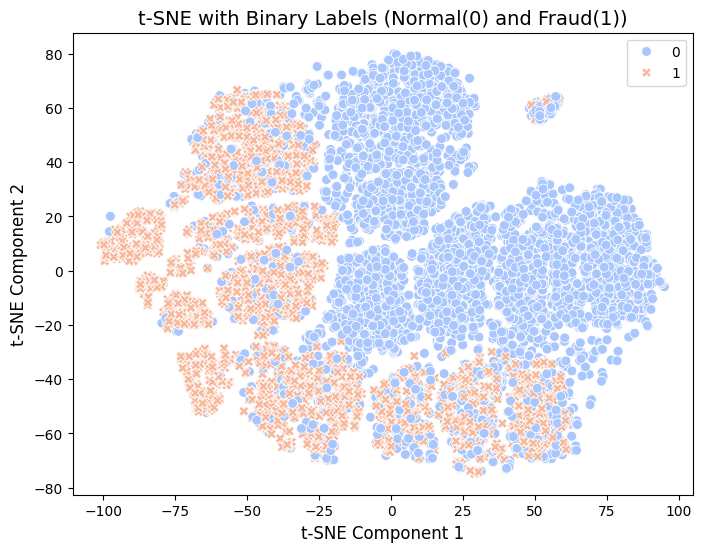

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_bin, palette="coolwarm", s=50, style=y_bin, legend="full")
plt.title('t-SNE with Binary Labels (Normal(0) and Fraud(1))', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

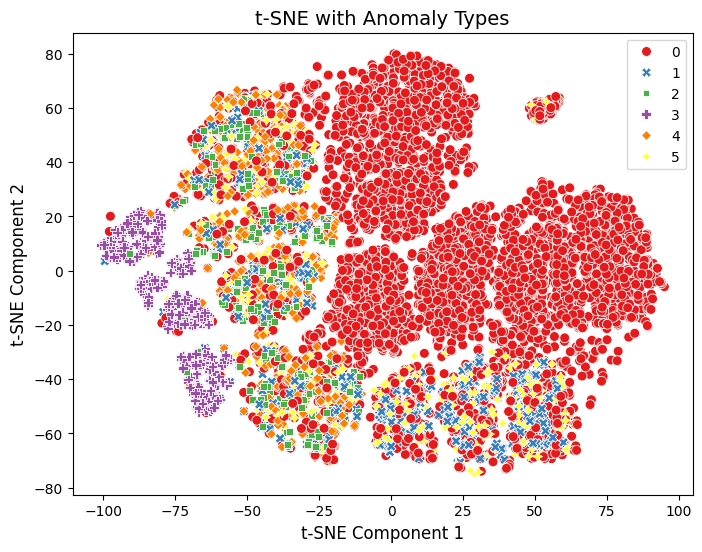

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="Set1", s=50, style=y, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

## UMAP

In [19]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(10000, 2)

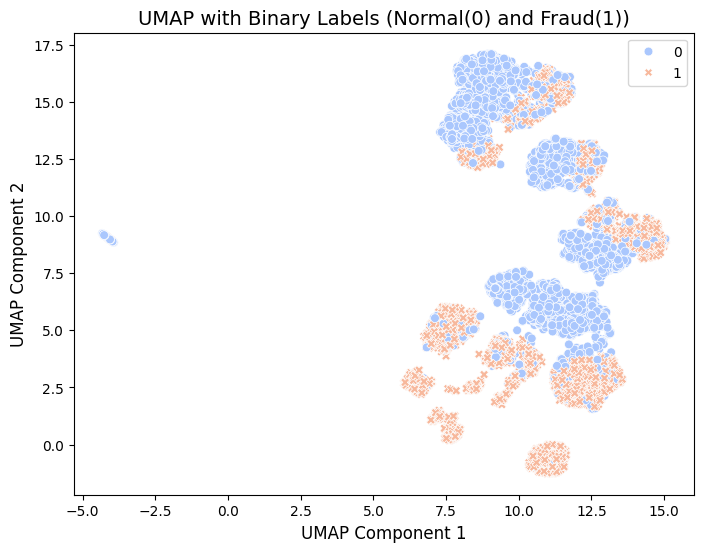

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_bin, palette="coolwarm", s=40, style=y_bin, legend="full")
plt.title('UMAP with Binary Labels (Normal(0) and Fraud(1))', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

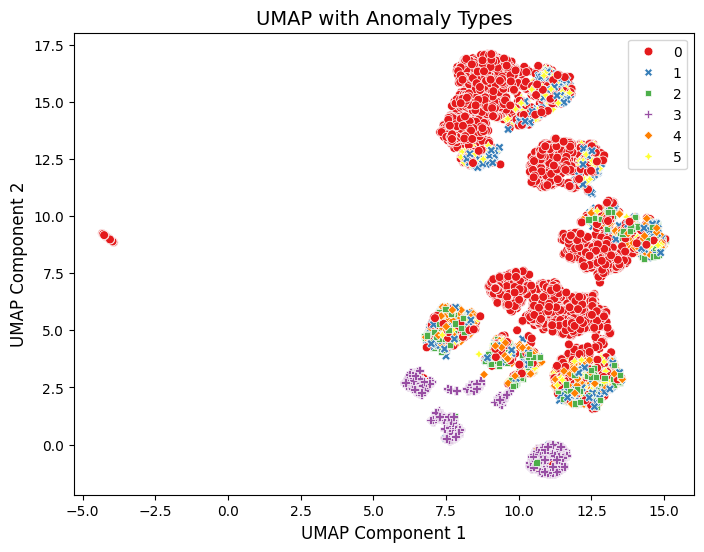

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, palette="Set1", s=40, style=y, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [5]:
#df = load_data(r'amaretto_transformed_scaled.pq')

## Transformed dataset

In [37]:
df = pl.read_parquet("amaretto_transformed_scaled.pq")

In [53]:
df

id,datetime,Originator,Anomaly,Anomaly_bin,amount_log,InputOutput_Buy,InputOutput_Sell,Market_1,Market_2,Market_3,Market_4,Product Type_ADR,Product Type_Bond,Product Type_CAADR,Product Type_ETOEquity,Product Type_ETOEquityIndex,Product Type_Equity,Product Type_FX,Product Type_FXForward,Product Type_FXSwap,Product Type_FutureBond,Product Type_FutureCommodity,Product Type_FutureEquity,Product Type_FutureEquityIndex,Product Type_FutureFX,Product Type_FutureOptionEquityIndex,Product Type_Repo,Product Type_SimpleTransfer,Product Class_ADR Conversion,"Product Class_Cash in / out (withdrawal), Security in / out",Product Class_External fee,Product Class_Trade,Currency_1,Currency_2,day_of_week,day_of_month,…,rolling_n_transactions_12h,rolling_n_transactions_24h,rolling_n_transactions_7d,rolling_mean_originator_1h,rolling_mean_originator_12h,rolling_mean_originator_24h,rolling_mean_originator_7d,rolling_std_originator_1h,rolling_std_originator_12h,rolling_std_originator_24h,rolling_std_originator_7d,rolling_max_originator_1h,rolling_max_originator_12h,rolling_max_originator_24h,rolling_max_originator_7d,rolling_min_originator_1h,rolling_min_originator_12h,rolling_min_originator_24h,rolling_min_originator_7d,rolling_sum_originator_1h,rolling_sum_originator_12h,rolling_sum_originator_24h,rolling_sum_originator_7d,rolling_n_transactions_originator_1h,rolling_n_transactions_originator_12h,rolling_n_transactions_originator_24h,rolling_n_transactions_originator_7d,cumcount_InputOutput,cumcount_Market,cumcount_Product Type,cumcount_Product Class,cumcount_Currency,InputOutput_freq_originator,Market_freq_originator,Product Type_freq_originator,Product Class_freq_originator,Currency_freq_originator
u32,datetime[μs],str,i64,i8,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
151925,2019-01-01 00:00:03,"""Client_259""",0,0,0.392679,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-15.681047,-19.407062,-34.615714,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
196838,2019-01-01 00:00:07,"""Client_133""",0,0,0.541257,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
463308,2019-01-01 00:00:07,"""Client_042""",0,0,-1.658164,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
570827,2019-01-01 00:00:08,"""Client_019""",0,0,0.646217,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2,1,…,-14.435015,-17.95024,-32.341037,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.75

In [54]:
labels = df["Anomaly"].to_numpy()
data = df.drop(["id", "Originator", "datetime", "Anomaly", "Anomaly_bin"]).to_numpy()

In [70]:
X, y = sample_shap_data(data, labels, n_samples=10000, anomaly_ratio=0.4)
y_bin = (y != 0) * 1

## t-SNE

In [71]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(10000, 2)

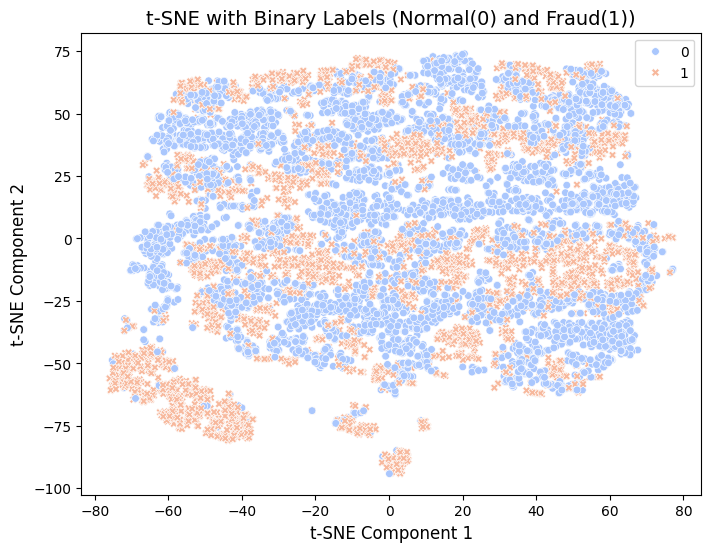

In [74]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_bin, palette="coolwarm", s=30, style=y_bin, legend="full")
plt.title('t-SNE with Binary Labels (Normal(0) and Fraud(1))', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

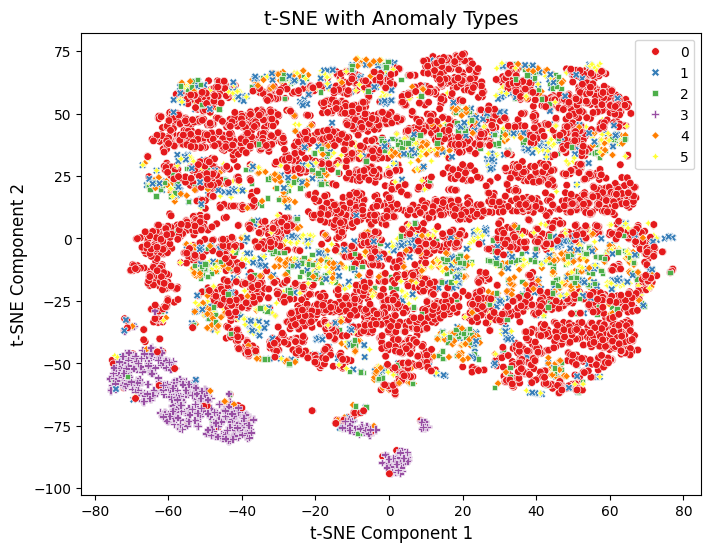

In [76]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

## UMAP

In [77]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(10000, 2)

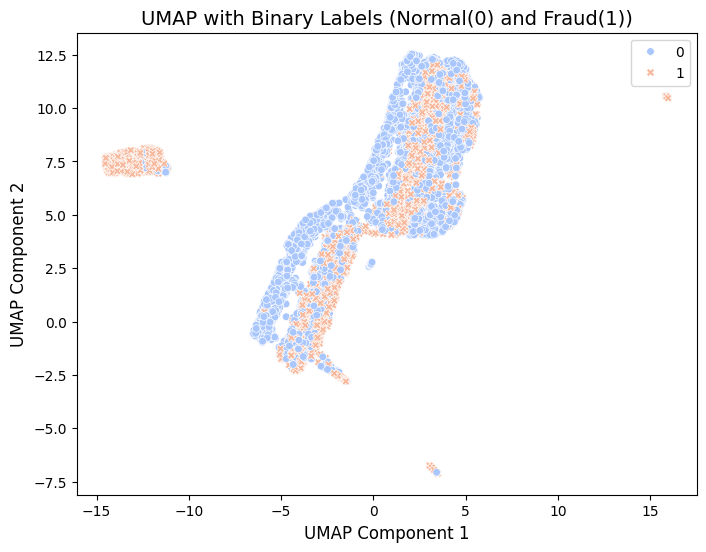

In [79]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_bin, palette="coolwarm", s=30, style=y_bin, legend="full")
plt.title('UMAP with Binary Labels (Normal(0) and Fraud(1))', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

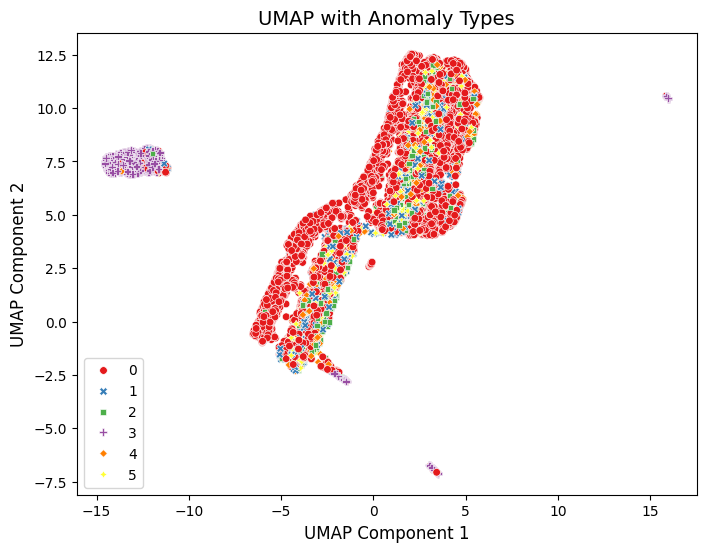

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

## Experiment #1 : Autoencoder only

In [2]:
df = pl.read_parquet("amaretto_transformed_scaled.pq")
df

id,datetime,Originator,Anomaly,Anomaly_bin,amount_log,InputOutput_Buy,InputOutput_Sell,Market_1,Market_2,Market_3,Market_4,Product Type_ADR,Product Type_Bond,Product Type_CAADR,Product Type_ETOEquity,Product Type_ETOEquityIndex,Product Type_Equity,Product Type_FX,Product Type_FXForward,Product Type_FXSwap,Product Type_FutureBond,Product Type_FutureCommodity,Product Type_FutureEquity,Product Type_FutureEquityIndex,Product Type_FutureFX,Product Type_FutureOptionEquityIndex,Product Type_Repo,Product Type_SimpleTransfer,Product Class_ADR Conversion,"Product Class_Cash in / out (withdrawal), Security in / out",Product Class_External fee,Product Class_Trade,Currency_1,Currency_2,day_of_week,day_of_month,…,rolling_n_transactions_12h,rolling_n_transactions_24h,rolling_n_transactions_7d,rolling_mean_originator_1h,rolling_mean_originator_12h,rolling_mean_originator_24h,rolling_mean_originator_7d,rolling_std_originator_1h,rolling_std_originator_12h,rolling_std_originator_24h,rolling_std_originator_7d,rolling_max_originator_1h,rolling_max_originator_12h,rolling_max_originator_24h,rolling_max_originator_7d,rolling_min_originator_1h,rolling_min_originator_12h,rolling_min_originator_24h,rolling_min_originator_7d,rolling_sum_originator_1h,rolling_sum_originator_12h,rolling_sum_originator_24h,rolling_sum_originator_7d,rolling_n_transactions_originator_1h,rolling_n_transactions_originator_12h,rolling_n_transactions_originator_24h,rolling_n_transactions_originator_7d,cumcount_InputOutput,cumcount_Market,cumcount_Product Type,cumcount_Product Class,cumcount_Currency,InputOutput_freq_originator,Market_freq_originator,Product Type_freq_originator,Product Class_freq_originator,Currency_freq_originator
u32,datetime[μs],str,i64,i8,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
151925,2019-01-01 00:00:03,"""Client_259""",0,0,0.392679,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-15.681047,-19.407062,-34.615714,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
196838,2019-01-01 00:00:07,"""Client_133""",0,0,0.541257,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
463308,2019-01-01 00:00:07,"""Client_042""",0,0,-1.658164,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,2,1,…,-14.73846,-18.305018,-32.894988,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.759253
570827,2019-01-01 00:00:08,"""Client_019""",0,0,0.646217,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2,1,…,-14.435015,-17.95024,-32.341037,-12.375985,-33.285581,-42.036975,-122.008372,-9.297571,-28.438271,-34.888399,-116.054396,-9.914659,-28.656326,-35.353446,-93.635163,-12.234035,-30.772611,-31.90101,-55.86845,-9.099869,-12.938788,-14.257223,-17.684867,-3.488935,-4.521771,-5.222825,-7.016616,-6.18689,-5.461002,-4.45734,-5.261721,-6.025219,19.130933,3.273489,10.168608,1.312785,1.75

In [3]:
df_train, df_val, df_test = split_data(df)
columns_to_drop = ['id', 'Anomaly', 'Anomaly_bin', 'Originator', 'datetime']

target_column = 'Anomaly'
y_train = df_train.select(target_column).to_numpy().flatten()
df_train = df_train.drop(columns_to_drop)
X_train = df_train.to_numpy()
y_val = df_val.select(target_column).to_numpy().flatten()
X_val = df_val.drop(columns_to_drop).to_numpy()
y_test = df_test.select(target_column).to_numpy().flatten()
X_test = df_test.drop(columns_to_drop).to_numpy()
print(X_train.shape)

train_dataset = AmarettoDataset(X_train, y_train)
val_dataset = AmarettoDataset(X_val, y_val)
test_dataset = AmarettoDataset(X_test, y_test)

(2030939, 125)


In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=2)
input_dim = X_train.shape[1]
print(len(train_loader))  # Should print an integer`

31734


In [9]:
model = train(train_loader, val_loader, input_dim, hidden_layers=[64], latent_dim=16, epochs=5, lr=0.0001)

Epoch 1/5 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.6722, Val Loss = 3.7133


Epoch 2/5 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.6721, Val Loss = 3.4191


Epoch 3/5 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.6035, Val Loss = 3.1187


Epoch 4/5 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.5748, Val Loss = 2.4556


Epoch 5/5 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.5479, Val Loss = 2.4240


In [109]:
model2 = train(train_loader, val_loader, input_dim, hidden_layers=[32, 16], latent_dim=2, epochs=9, lr=0.0001)

Epoch 1/9 [Training]:   0%|          | 0/31734 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
X, y = sample_data(X_test, y_test, n_samples=10000, anomaly_ratio=0.1)
y_bin = (y != 0) * 1

[ 66  38 212 542 530]


In [79]:
X = X_test[y_test != 0]
y = y_test[y_test != 0]
X.shape

(1388, 125)

In [80]:
y_bin = (y != 0) * 1
y_bin.shape

(1388,)

In [81]:
model.eval()
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    z_test = model.encode(X_tensor)

In [82]:
z_test = z_test.cpu().numpy()


In [83]:
z_test.shape

(1388, 16)

In [84]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_test)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1388, 2)

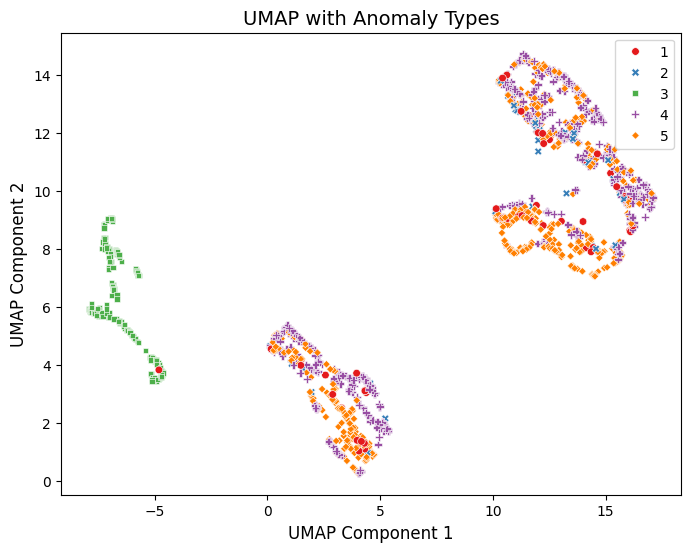

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [87]:
X_embedded = TSNE(n_components=2).fit_transform(z_test)
X_embedded.shape

(1388, 2)

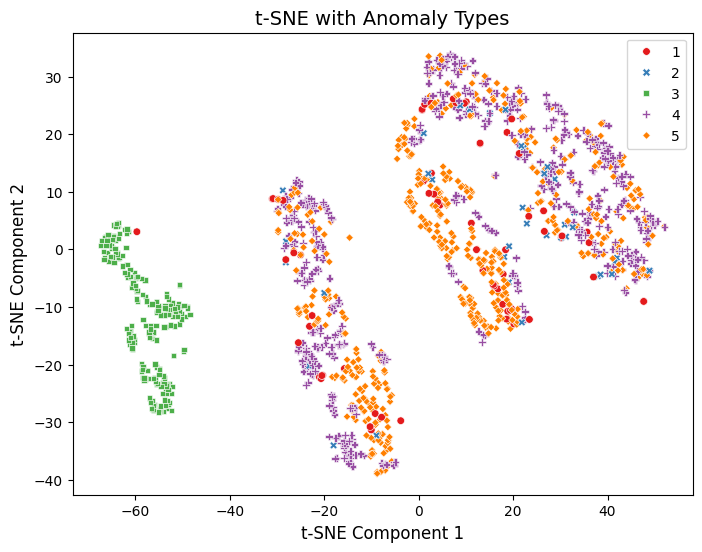

In [89]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="Set1", s=30, style=y, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [102]:
X = X_test[y_test != 0]
y = y_test[y_test != 0]
X.shape
model2.eval()
X_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    z_test = model2.encode(X_tensor)
z_test = z_test.cpu().numpy()
z_test.shape

(1388, 3)

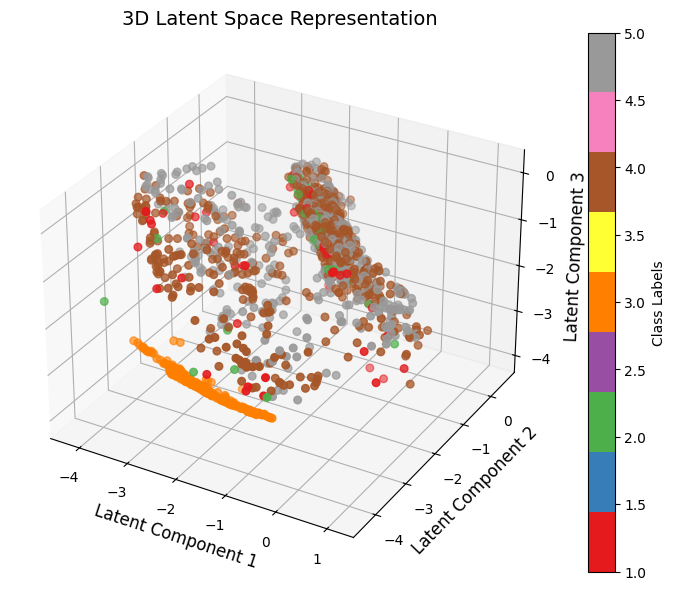

In [107]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot
sc = ax.scatter(z_test[:, 0], z_test[:, 1], z_test[:, 2], c=y, cmap="Set1", s=30)

ax.set_title("3D Latent Space Representation", fontsize=14)
ax.set_xlabel("Latent Component 1", fontsize=12)
ax.set_ylabel("Latent Component 2", fontsize=12)
ax.set_zlabel("Latent Component 3", fontsize=12)
# Add color legend
plt.colorbar(sc, ax=ax, label="Class Labels")
plt.show()

## Experiment #2: Autoencoder -> Latent Space -> Classification

In [8]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([1.6709e-01, 9.4025e+02, 1.8497e+03, 3.2422e+02, 1.4918e+02, 2.5111e+02])

In [129]:
model.eval()
X_tensor = torch.tensor(X_train, dtype=torch.float32)
with torch.no_grad():
    z_train = model.encode(X_tensor)
#z_train = z_train.cpu().numpy()
print(z_train.shape)

X_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    z_val = model.encode(X_tensor)
#z_val = z_val.cpu().numpy()
z_val.size()

torch.Size([2030939, 16])


torch.Size([555044, 16])

In [130]:
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [135]:
mlp_classifier = train_classifier(z_train, y_train_tensor, z_val, y_val_tensor, latent_dim=z_train.shape[1], num_classes=6, epochs=5, lr=0.0001, class_weights=class_weights)

[autoreload of autoencoder failed: Traceback (most recent call last):
  File "/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/mnt/appl/software/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/darosali/BP/amaretto/autoencoder.py", line 163
  

Epoch 1/5 [Training Classifier]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 1: Train Class Loss = 0.5709, Val Class Loss = 0.7228


Epoch 2/5 [Training Classifier]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 2: Train Class Loss = 0.3907, Val Class Loss = 0.6322


Epoch 3/5 [Training Classifier]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 3: Train Class Loss = 0.3108, Val Class Loss = 0.5882


Epoch 4/5 [Training Classifier]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 4: Train Class Loss = 0.2762, Val Class Loss = 0.5321


Epoch 5/5 [Training Classifier]:   0%|          | 0/31734 [00:00<?, ?it/s]

Epoch 5: Train Class Loss = 0.2578, Val Class Loss = 0.5160


In [139]:
def predict_labels(classifier, model, x):
    with torch.no_grad():
        z = encoder(x)  # Encode input into latent space
        logits = classifier(z)  # Get raw outputs (logits)
        predictions = torch.argmax(logits, dim=1)  # Get predicted class labels
    return predictions

In [191]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_pred = predict_labels(mlp_classifier, model.encoder, X_test_tensor)

In [192]:
y_pred = y_pred.cpu().detach().numpy()
y_pred.shape

(555044,)

In [194]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553656
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        38
           3       0.19      0.02      0.04       212
           4       0.48      0.50      0.49       542
           5       0.07      0.04      0.05       530

    accuracy                           1.00    555044
   macro avg       0.29      0.26      0.26    555044
weighted avg       1.00      1.00      1.00    555044



/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [162]:
err = y_test[y_test != y_pred]

In [165]:
err[err != 0].shape

(1094,)

In [173]:
  def train_xgboost_classifier(latent_train, y_train, latent_val, y_val):
        model = xgb.XGBClassifier(
            objective="multi:softmax",
            num_class=len(np.unique(y_train)),
            eval_metric="mlogloss",
            use_label_encoder=False
        )
        
        model.fit(latent_train, y_train, eval_set=[(latent_val, y_val)], verbose=True)
        return model

In [174]:
xgb_classifier = train_xgboost_classifier(z_train.cpu().detach().numpy(), y_train, z_val.cpu().detach().numpy(), y_val)

[0]	validation_0-mlogloss:0.99709


/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [04:16:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.67644
[2]	validation_0-mlogloss:0.47962
[3]	validation_0-mlogloss:0.34756
[4]	validation_0-mlogloss:0.25541
[5]	validation_0-mlogloss:0.19003
[6]	validation_0-mlogloss:0.14271
[7]	validation_0-mlogloss:0.10843
[8]	validation_0-mlogloss:0.08338
[9]	validation_0-mlogloss:0.06523
[10]	validation_0-mlogloss:0.05214
[11]	validation_0-mlogloss:0.04236
[12]	validation_0-mlogloss:0.03521
[13]	validation_0-mlogloss:0.03010
[14]	validation_0-mlogloss:0.02632
[15]	validation_0-mlogloss:0.02371
[16]	validation_0-mlogloss:0.02156
[17]	validation_0-mlogloss:0.02014
[18]	validation_0-mlogloss:0.01901
[19]	validation_0-mlogloss:0.01825
[20]	validation_0-mlogloss:0.01762
[21]	validation_0-mlogloss:0.01726
[22]	validation_0-mlogloss:0.01699
[23]	validation_0-mlogloss:0.01671
[24]	validation_0-mlogloss:0.01650
[25]	validation_0-mlogloss:0.01636
[26]	validation_0-mlogloss:0.01613
[27]	validation_0-mlogloss:0.01596
[28]	validation_0-mlogloss:0.01581
[29]	validation_0-mlogloss:0.

In [178]:
X_test_tensor.shape

torch.Size([555044, 125])

In [195]:
X_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    z_test = model.encode(X_tensor)
z_test = z_val.cpu().numpy()
z_test.shape

(555044, 16)

In [197]:
preds = xgb_classifier.predict(z_test)

In [198]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553656
           1       0.50      0.02      0.03        66
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00       212
           4       0.54      0.08      0.14       542
           5       0.18      0.05      0.07       530

    accuracy                           1.00    555044
   macro avg       0.37      0.19      0.21    555044
weighted avg       1.00      1.00      1.00    555044



/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [190]:
err[err != 0].shape

(1003,)

## Experiment #3: End-to-end model

In [ ]:
model_combined = train_combined(train_loader, val_loader, input_dim, hidden_layers=[64, 32], latent_dim=16, num_classes=6, epochs=5, lr=0.0001, alpha=0.5, class_weights=class_weights)

In [10]:
model_combined.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    _, y_pred, z_test = model_combined(X_test_tensor)
    y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.cpu().detach().numpy()
print(y_pred.shape)
z_test = z_test.cpu().numpy()
print(z_test.shape)

(555044,)
(555044, 16)


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553656
           1       0.17      0.06      0.09        66
           2       1.00      0.03      0.05        38
           3       0.00      0.00      0.00       212
           4       0.29      0.68      0.41       542
           5       0.42      0.48      0.45       530

    accuracy                           1.00    555044
   macro avg       0.48      0.37      0.33    555044
weighted avg       1.00      1.00      1.00    555044



/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [12]:
y_pred_a = y_pred[y_pred != 0]
z_test_a = z_test[y_pred != 0]
z_test_a.shape

(1899, 16)

In [13]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(z_test_a)
embedding.shape

/home/darosali/BP/amaretto/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1899, 2)

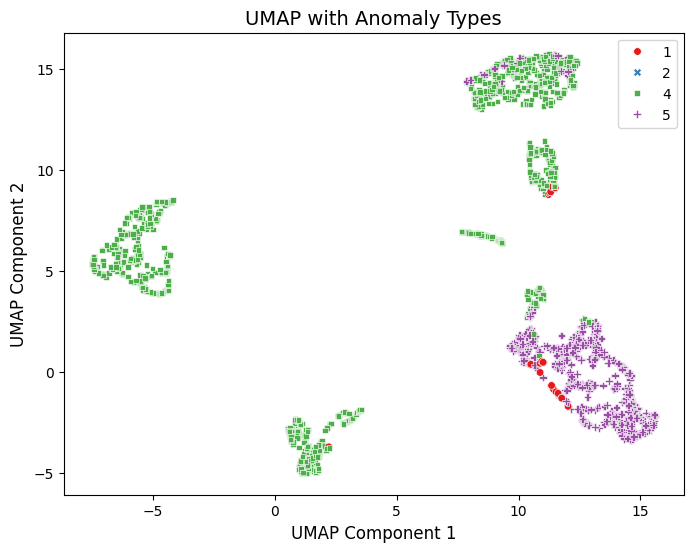

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_pred_a, palette="Set1", s=30, style=y_pred_a, legend="full")
plt.title('UMAP with Anomaly Types', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()

In [15]:
X_embedded = TSNE(n_components=2).fit_transform(z_test_a)
X_embedded.shape

(1899, 2)

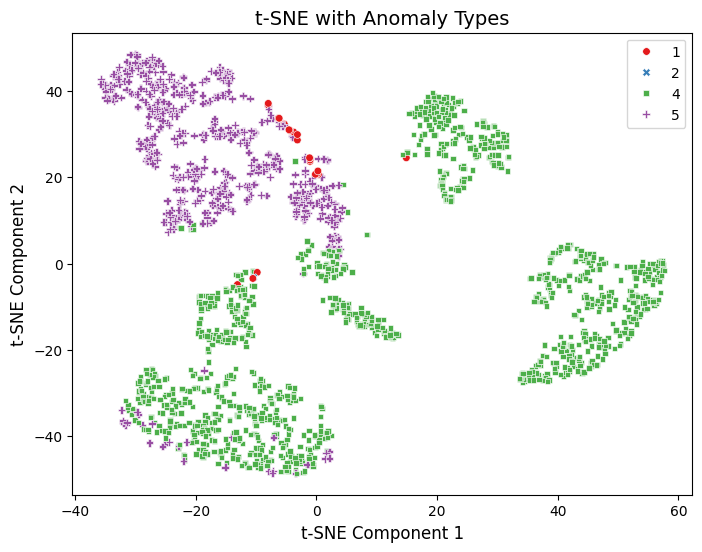

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_pred_a, palette="Set1", s=30, style=y_pred_a, legend="full")
plt.title('t-SNE with Anomaly Types', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
#plt.legend(title="Labels", labels=["Normal", "Fraud"])
plt.show()